In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pose_vector_to_transformation_matrix import \
    pose_vector_to_transformation_matrix
from project_points import project_points
from undistort_image import undistort_image
from compute_relative_extrinsics import compute_relative_extrinsics

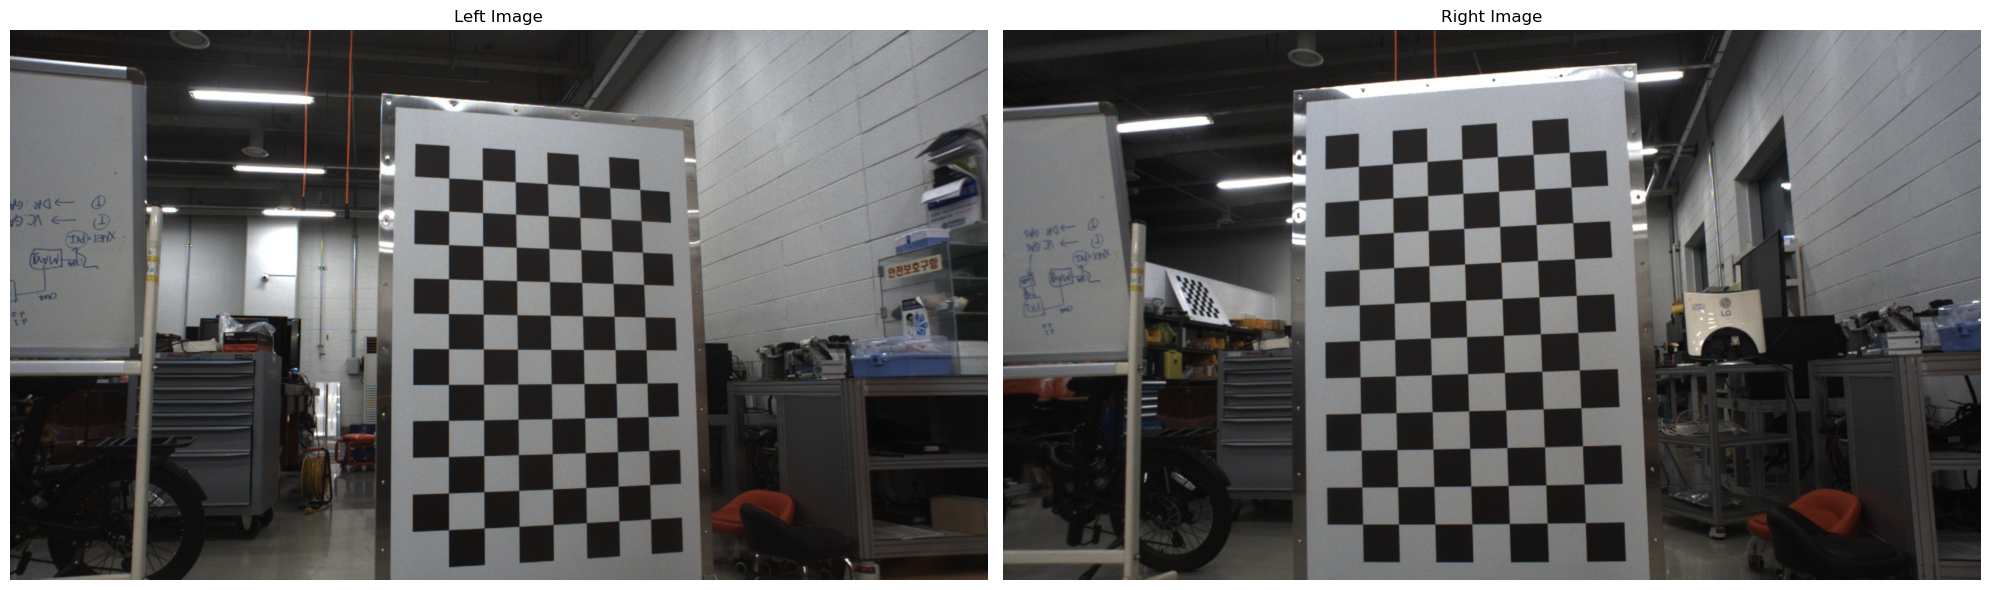

In [169]:
# load camera intrinsics
K_right = np.loadtxt('data/K_1.txt')  
K_left = np.loadtxt('data/K_2.txt')

D_right = np.loadtxt('data/D_1.txt')  
D_left = np.loadtxt('data/D_2.txt')

pose_vectors_right = np.loadtxt('data/all_pose_vectors_1.txt')
pose_vectors_left = np.loadtxt('data/all_pose_vectors_2.txt')

img_index = 15
img_right = cv2.imread('data/images/cam1/cam1_{0:04d}.jpg'.format(img_index))
img_left = cv2.imread('data/images/cam2/cam2_{0:04d}.jpg'.format(img_index))
height, width, _ = img_right.shape

# Create a figure with larger size
plt.figure(figsize=(20, 10))  # Adjust the figsize to make the images larger

# Plot the left image with epilines
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))  # Convert to RGB for proper display
plt.axis('off')  # Turn off axis
plt.title('Left Image')

# Plot the right image with epilines
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))  # Convert to RGB for proper display
plt.axis('off')  # Turn off axis
plt.title('Right Image')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [159]:
# 두 카메라의 Extrinsic Parameter 추출 (R, t)
T_C_W_right = pose_vector_to_transformation_matrix(pose_vectors_right[img_index - 1, :]) # World to Camera Transformation Matrix
T_C_W_left = pose_vector_to_transformation_matrix(pose_vectors_left[img_index - 1, :]) # World to Camera Transformation Matrix

R_right = T_C_W_right[:3, :3] # Rotation Matrix
t_right = T_C_W_right[:3, 3] # Translation Matrix 

R_left = T_C_W_left[:3, :3] # Rotation Matrix
t_left = T_C_W_left[:3, 3] # Translation Matrix

R_rel, t_rel = compute_relative_extrinsics(R_left, t_left, R_right, t_right)

print("Relative Rotation Matrix :\n", R_rel)
print("Relative Translation Matrix :\n", t_rel)

Relative Rotation Matrix :
 [[ 0.95189349  0.06014041  0.30046949]
 [-0.05259399  0.99806564 -0.03314879]
 [-0.30188185  0.01575123  0.95321521]]
Relative Translation Matrix :
 [-837.2158161    26.74820796    9.4662497 ]


# Essential Matrix E 
## Camera Coord. 1 -> Camera Coord. 2

In [160]:
# [TODO] Skew_symmetric Matrix
def skew_symmetric(t):
    """
    Convert a 3D vector into a skew-symmetric matrix.
    """
    return np.array([
    ])

skew_matrix = skew_symmetric(t_rel)

# [TODO] Compute Essential Matix E = t_x * R
E = 

print("Essential Matrix :\n", E)

Essential Matrix :
 [[  -7.57693075   -9.02662139   25.81059355]
 [-243.72940064   13.75648411  800.89117302]
 [  18.57107487 -837.20499088   19.71567351]]


In [161]:
%matplotlib inline
square_size = 100  # [mm]
num_corners_x = 7
num_corners_y = 11
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y],
                                        axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate(
    [p_W_corners, np.zeros([num_corners, 1])], axis=-1)

# 랜덤하게 10개의 점만 선택
num_points = 20
random_indices = np.random.choice(num_corners, size=num_points, replace=False)
p_W_corners = p_W_corners[random_indices]

# transform 3d points from world to current camera pose
p_C_corners_left = np.matmul(T_C_W_left[None, :, :],
                        np.concatenate([p_W_corners, np.ones([num_points, 1])], axis=-1)[:, :, None]).squeeze(-1)
p_C_corners_left = p_C_corners_left[:, :3]

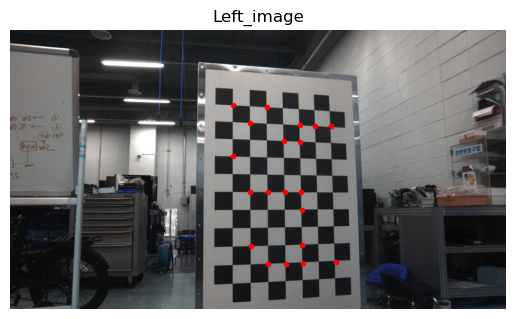

In [162]:
projected_pts_left = project_points(p_C_corners_left, K_left, D_left)
plt.imshow(img_left, cmap='gray')
plt.plot(projected_pts_left[:, 0], projected_pts_left[:, 1], 'o', markersize=3, color='r')
plt.title('Left_image')
plt.axis('off')
plt.show()

# Fundamental Matrix F
## Image Plane Coord. 1 -> Image Plane Coord. 2

In [163]:
# [TODO] Compute Fundamental Matix F = K_l_inv().T * E * K_r_inv()
F = 

print("Fundamental Matrix :\n", F)

Fundamental Matrix :
 [[-6.01639391e-06 -7.16913281e-06  3.11061529e-02]
 [-1.93688229e-04  1.09345575e-05  8.63106594e-01]
 [ 1.10328000e-01 -7.45962896e-01 -6.84044979e+01]]


# Draw Epipolar Line in Right Image

In [164]:
homo_projected_pts = np.concatenate([projected_pts_left, np.ones([num_points, 1])], axis=-1)

# epipolar line : ax + by + c = 0, F * xl
epipolar_line = np.matmul(F, homo_projected_pts.T).T
print("Epipolar_line :\n", epipolar_line)

Epipolar_line :
 [[ 2.38663757e-02  7.28552396e-01 -2.93240408e+02]
 [ 2.50586489e-02  7.26722968e-01 -1.69142234e+02]
 [ 2.04661774e-02  6.88116172e-01 -4.81440819e+02]
 [ 2.20325957e-02  6.97403474e-01 -3.60834274e+02]
 [ 2.14405700e-02  7.20507989e-01 -5.03021615e+02]
 [ 1.94293081e-02  6.67824626e-01 -5.09935818e+02]
 [ 2.29696862e-02  6.75703371e-01 -1.89750233e+02]
 [ 2.43566953e-02  7.05605363e-01 -1.61644345e+02]
 [ 2.26495769e-02  6.65962359e-01 -1.85928721e+02]
 [ 2.23639244e-02  7.07989198e-01 -3.66616591e+02]
 [ 2.00422692e-02  6.88488886e-01 -5.24555354e+02]
 [ 2.43133676e-02  7.16593189e-01 -2.05795782e+02]
 [ 2.12988530e-02  6.87384708e-01 -3.96754044e+02]
 [ 2.27019568e-02  7.18789096e-01 -3.72515877e+02]
 [ 2.06805024e-02  7.10003258e-01 -5.39770877e+02]
 [ 2.32366028e-02  6.96157662e-01 -2.37698508e+02]
 [ 2.03581354e-02  6.99136677e-01 -5.32086255e+02]
 [ 2.32959408e-02  6.85631557e-01 -1.93645734e+02]
 [ 2.17077750e-02  6.87025654e-01 -3.55165460e+02]
 [ 2.29058641e

In [165]:
def draw_epipolar_lines(image, lines, points):
    
    h, w, _ = image.shape  # Image dimensions

    # Convert image to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.figure(figsize=(20, 10))
    plt.imshow(image_rgb)
    
    # Define colors for lines and points
    colors = [
        "blue", "green", "red", "cyan", "magenta", "yellow",
        "darkblue", "darkgreen", "darkred", "olive"
    ]
    
    # Draw epipolar lines
    for i, r in enumerate(lines):
        a, b, c = r
        # Compute two points on the line for plotting
        x0, y0 = 0, -c / b if b != 0 else 0  # Line at x=0
        x1, y1 = w, -(a * w + c) / b if b != 0 else h  # Line at x=w
        
        # Plot the line
        plt.plot([x0, x1], [y0, y1], color=colors[i % len(colors)], linewidth=2, label=f"Line {i+1}")
    
    # Draw the points
    for i, p in enumerate(points):
        x, y = p[0], p[1]
        plt.scatter(x, y, color=colors[i % len(colors)], s=50, label=f"Point {i+1}")
    
    # Add legend and axis options
    plt.axis("off")
    plt.show()

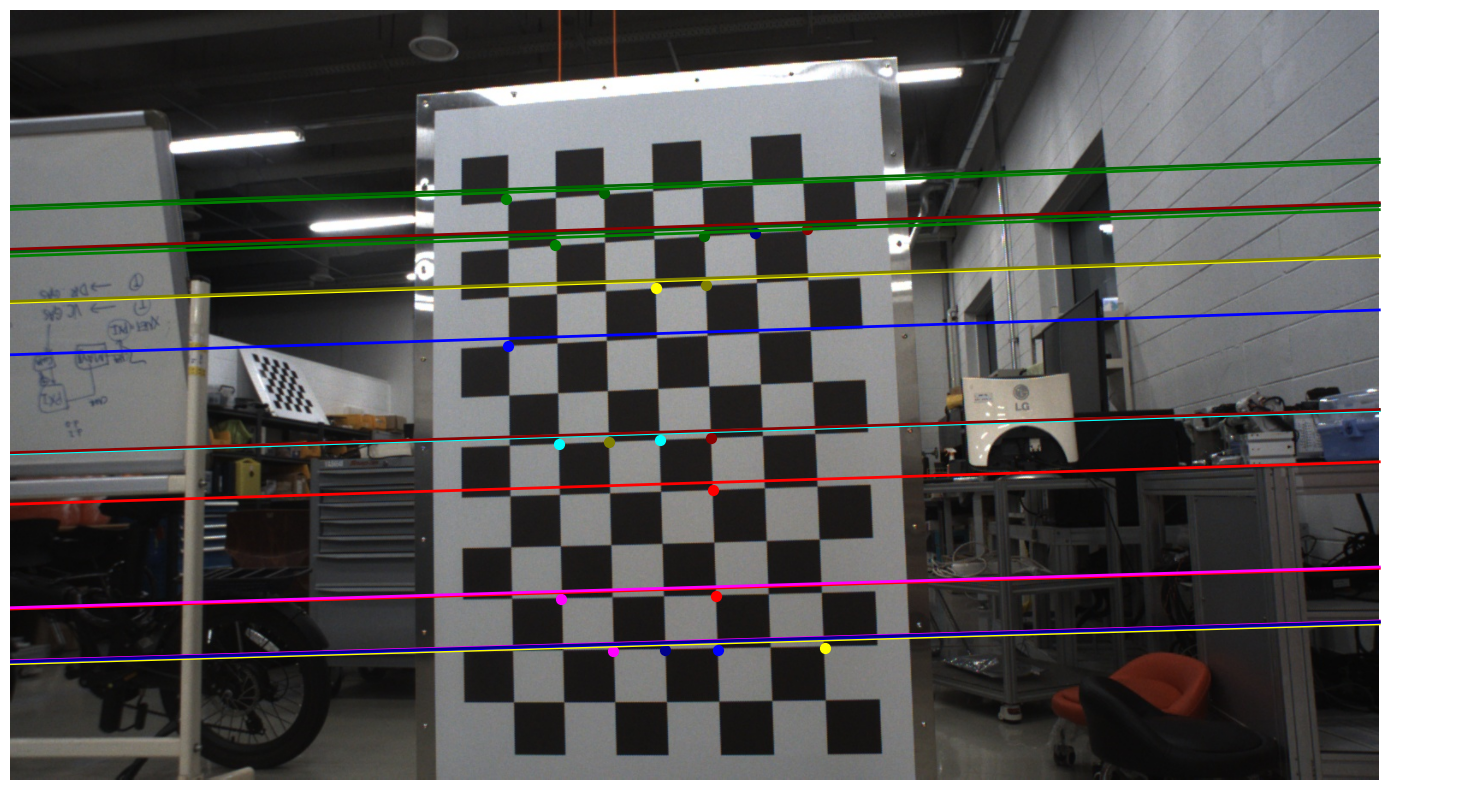

In [166]:
p_C_corners_right = np.matmul(T_C_W_right[None, :, :],
                        np.concatenate([p_W_corners, np.ones([num_points, 1])], axis=-1)[:, :, None]).squeeze(-1)
p_C_corners_right = p_C_corners_right[:, :3]

projected_pts_right = project_points(p_C_corners_right, K_right, D_right)

# Draw epipolar lines
draw_epipolar_lines(img_right, epipolar_line, projected_pts_right)

# Draw Epipolar Line in Left Image

In [167]:
homo_projected_pts = np.concatenate([projected_pts_right, np.ones([num_points, 1])], axis=-1)

# epipolar line : ax + by + c = 0, F * xl
epipolar_line = np.matmul(F.T, homo_projected_pts.T).T
print("Epipolar_line :\n", epipolar_line)

Epipolar_line :
 [[ 3.09503334e-02 -7.45848682e-01  2.87813996e+02]
 [ 6.40915692e-02 -7.47705143e-01  1.40122900e+02]
 [-2.71695928e-02 -7.44393663e-01  5.47850741e+02]
 [ 8.50389501e-03 -7.45912274e-01  3.88600422e+02]
 [-2.67898768e-02 -7.43056233e-01  5.45381196e+02]
 [-3.97704863e-02 -7.44635961e-01  6.04548034e+02]
 [ 5.48098992e-02 -7.49365080e-01  1.82733071e+02]
 [ 6.48555472e-02 -7.48600923e-01  1.37206328e+02]
 [ 5.51535585e-02 -7.49835251e-01  1.81459574e+02]
 [ 8.42622299e-03 -7.45462537e-01  3.88691736e+02]
 [-3.93567456e-02 -7.43720932e-01  6.02167445e+02]
 [ 5.34790226e-02 -7.47537060e-01  1.87660771e+02]
 [-3.20367476e-03 -7.45716598e-01  4.41037479e+02]
 [ 8.34937044e-03 -7.45017891e-01  3.88782284e+02]
 [-3.89583914e-02 -7.42827010e-01  5.99867993e+02]
 [ 4.29097581e-02 -7.47818716e-01  2.35261688e+02]
 [-3.91557332e-02 -7.43271394e-01  6.01008007e+02]
 [ 5.44708163e-02 -7.48900292e-01  1.83989106e+02]
 [ 8.58244904e-03 -7.46367204e-01  3.88508121e+02]
 [ 4.31825732e

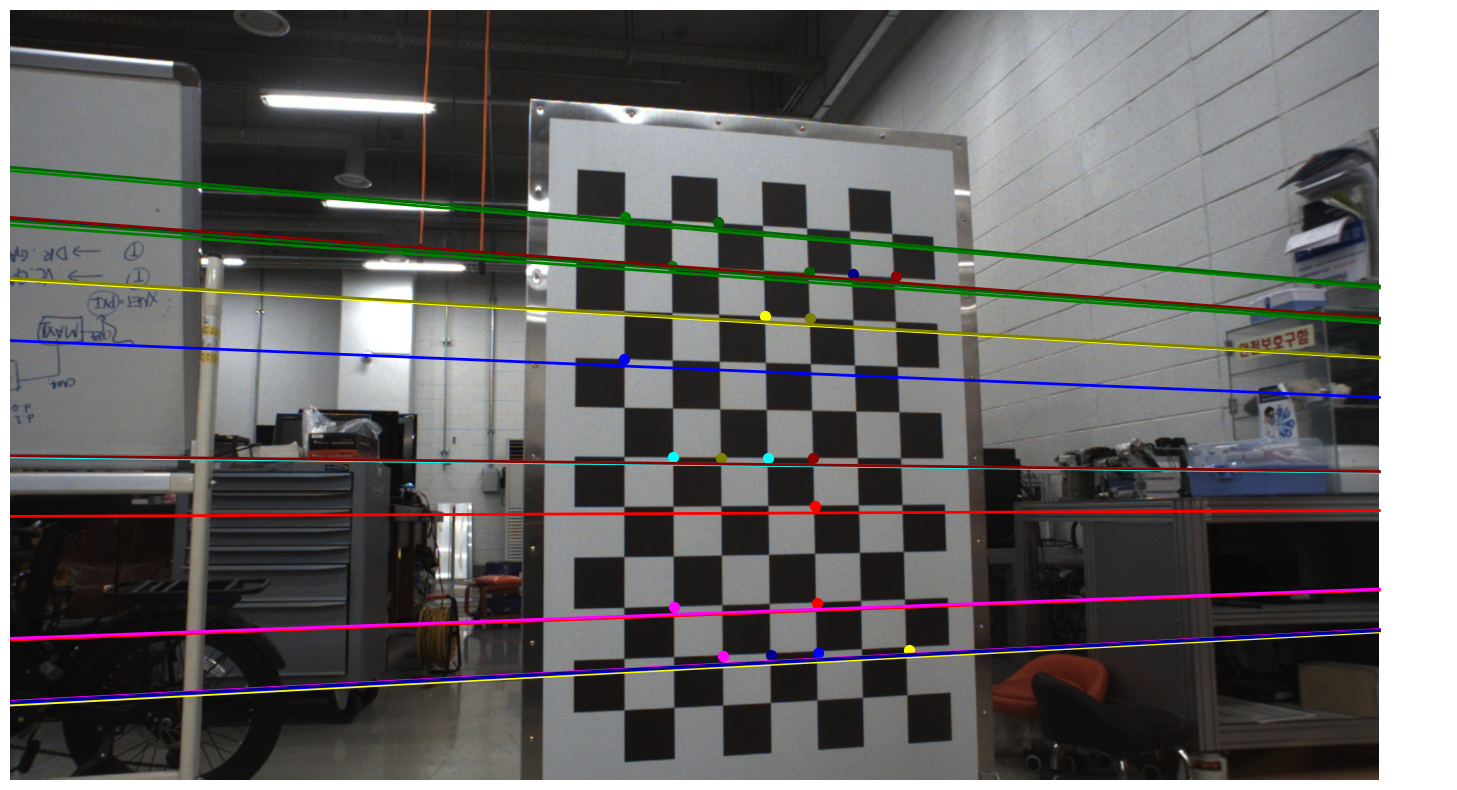

In [168]:
p_C_corners_left = np.matmul(T_C_W_left[None, :, :],
                        np.concatenate([p_W_corners, np.ones([num_points, 1])], axis=-1)[:, :, None]).squeeze(-1)
p_C_corners_left = p_C_corners_left[:, :3]

projected_pts_left = project_points(p_C_corners_left, K_left, D_left)

# Draw epipolar lines
draw_epipolar_lines(img_left, epipolar_line, projected_pts_left)